In [2]:
# Using code from:
# https://alexforrest.github.io/scraping-billboard-top-100-on-wikipedia.html
# Owner: Alex Harlan

%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import time
import seaborn as sns

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt


pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
import requests 
from bs4 import BeautifulSoup

req = requests.get('http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970')
page = req.text
soup = BeautifulSoup(page, 'html.parser')
tables_wikitable = soup.find_all('table', 'wikitable')
rows = [row for row in tables_wikitable[0].find_all('tr')]


def get_td(row):
    return [td for td in row.find_all('td')]

def get_rank(td):
    return td[0].string

def get_url(td):
    return td[2].a['href']

def get_band_singer(td):
    return td[2].a.string

def get_title(td):
    if td[1].a:
        return td[1].a['title']
    else:
        return td[1].string
    
    
#formating test
td_list = [get_td(row)for row in rows[1:]]
list_of_dicts = [{'url':get_url(td), 'ranking':get_rank(td), 
                'band_singer': get_band_singer(td), 'title':get_title(td)} 
                for td in td_list]

In [4]:
#generate list of urls 
urls = ['http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_{0}'.format(str(i)) for i in range(1970, 2020)]

def get_text(urls):
    """"""
    yearstext = {}
    for url in urls:
        req = requests.get(url)
        yearstext[url.split('_')[-1]] = req.text
        time.sleep(1)
    return yearstext

yearstext = get_text(urls)

In [5]:
def parse_year(the_year, yeartext_dict):
    """
    Inputs
    ------
    the_year: 
    yeartext_dict: a dictionary with keys as integer years and values the downloaded web pages 
    from wikipedia for that year.
   
    Returns
    -------

    a list of dictionaries corresponding to a single, with dictionaries formated:

        band_singer: a list of bands/singers who made this single
        song: a list of the titles of songs on this single
        songurl: a list of the same size as song which has urls for the songs on the single 
            (see point 3 above)
        ranking: ranking of the single
        titletext: the contents of the table cell
        band_singer: a list of bands or singers on this single
        url: a list of wikipedia singer/band urls on this single: only put in the part 
        of the url from /wiki onwards
    
"""

    soup = BeautifulSoup(yeartext_dict[str(the_year)], 'html.parser')
    tables_wikitable = soup.find_all('table', 'wikitable')
    rows = [row for row in tables_wikitable[0].find_all('tr')][1:]
    yearinfo = [get_single_dict(row) for row in rows]
    return yearinfo



def get_single_dict(row):
    """
    input: list of contents in single row
    output: dictionary of content from single row
    """
    
    children = [child for child in row.children]
    children = list(filter(lambda x: x != '\n', children))
    ranking = children[0].string
    band_singers = children[2].find_all('a')
    band_singer = [band.string for band in band_singers]
    url = [url['href'] for url in band_singers]
    songs = children[1].find_all('a')
    songurl = [song['href'] for song in songs]
    
    #handles edge cases where row content is missing
    if songurl == []:
        songurl = [None]
    song = [song.string for song in songs]
    if not song:
        song = children[1].string
        
    if type(song) == list:
        title = '/'.join(str(s) for s in song)
    else:
        title = song

    single_dict = {'band_singer': band_singer, 'ranking': ranking, 'song': song,
                   'songurl':songurl, 'titletext':title, 'url': url}
    return single_dict

In [6]:
#test to make sure parse_year runs correctly

yearinfo = parse_year(1997, yearstext)


In [7]:
import json

In [8]:
for year in range(1970, 2020):
    yearinfo = parse_year(year, yearstext)
    fd = open("data/{0}info.json".format(str(year)),"w")
    json.dump(yearinfo, fd)
    fd.close()
  
    #create DataFrame for Billboard Hot 100's: 1970-2014
    with open("data/{0}info.json".format(str(year)), "r") as f:
        curyearinfo = json.load(f)
       
        if year == 1970:
            
            flatframe = pd.DataFrame(curyearinfo)
            flatframe['year'] = year
        else:
            year_df = pd.DataFrame(curyearinfo)
            year_df['year'] = year
            flatframe = flatframe.append(year_df)

    

In [9]:
flatframe.reset_index(inplace = True)

In [10]:

cols = ['band_singer', 'song', 'songurl', 'url']
for col in cols:
    flatframe[col] = flatframe[col].apply(lambda x: x[0] if type(x) == list and len(x)==1 else x) 
    
bands_expanded = flatframe.apply(lambda x: pd.Series(x['band_singer']),axis=1).stack().reset_index(level=1, drop=True)
urls_expanded = flatframe.apply(lambda x: pd.Series(x['url']),axis=1).stack().reset_index(level=1, drop=True)
df_bandrows = pd.concat([bands_expanded, urls_expanded], axis = 1)
df_bandrows.columns = ['band_singer', 'url']

flatframe = flatframe.drop(df_bandrows.columns, axis=1).join(df_bandrows)
#clean rankings, strip new line
flatframe.ranking = flatframe.ranking.str.strip('\n')

In [11]:
newframe =flatframe[flatframe.song.apply(lambda x: type(x) == list)]
flatframe_dropped = flatframe[flatframe.song.apply(lambda x: type(x) != list)]

songs_expanded = newframe.apply(lambda x: pd.Series(x['song']),axis=1).stack().reset_index(level=1, drop=True)
songurls_expanded = newframe.apply(lambda x: pd.Series(x['songurl']),axis=1).stack().reset_index(level=1, drop=True)


df_expanded = pd.concat([songs_expanded, songurls_expanded], axis = 1)
df_expanded.columns = ['song', 'songurl']

flatframe = flatframe.drop(df_expanded.columns, axis = 1).join(df_expanded, how = 'inner')
flatframe = pd.concat([flatframe_dropped, flatframe], sort = True)
flatframe = flatframe[['ranking', 'band_singer','song', 'songurl', 
                         'titletext', 'url', 'year']]

In [12]:
flatframe = flatframe[~flatframe.ranking.isna()]

In [13]:
#handle case of ranking ties
flatframe.loc[:,0] = flatframe.ranking.apply(lambda x: '0' if x == 'Tie' else x)

flatframe = flatframe.astype({'ranking': int, 'url': str})
tied_rankings = flatframe[flatframe.ranking == 0].index
tied_values = [38, 55,86, 92, 92]
for i, tie in enumerate(tied_rankings):
    flatframe.loc[tie, 'ranking' ] = tied_values[i]

In [14]:
with open("data/2019info.json", "r") as fd:
    yearinfo = json.load(fd)

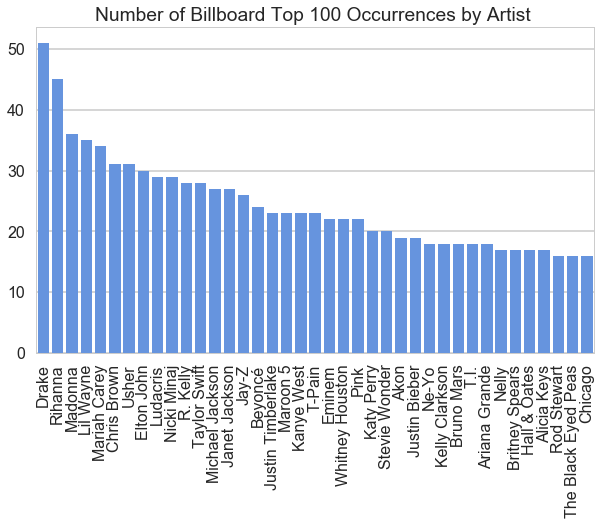

In [15]:
quality_counts = flatframe.band_singer.value_counts() 

quality_bands = quality_counts[quality_counts.values>15]

f = plt.figure(figsize = (10,6), frameon = False)
sns.barplot(quality_bands.index, quality_bands.values, color = '#528ff2')
xticks = plt.xticks(rotation=90)
title = plt.title("Number of Billboard Top 100 Occurrences by Artist ");
